In [1]:
__author__ = 'racah'
import os
import pickle
import sys
from neon.data import DataIterator
from neon.layers import Conv, Pooling, GeneralizedCost, Deconv
from data_transform import DataTransform
from neon.models import Model
from neon.optimizers import GradientDescentMomentum
from neon.transforms import Rectlin, SumSquared
from neon.callbacks.callbacks import Callbacks, LossCallback
from neon.util.argparser import NeonArgparser
import h5py
import matplotlib
import sklearn
from sklearn.manifold import TSNE
from data_loaders import load_dayabay_conv
from he_initializer import HeWeightInit
from tsne_visualize import Vis
from util.helper_fxns import plot_train_val_learning_curve,\
    save_orig_data, \
    save_middle_layer_output, \
    adjust_train_val_test_sizes, create_h5_file, stop_func, get_middle_layer_output
import numpy as np
matplotlib.use('agg')
from matplotlib import pyplot as plt

In [ ]:
# 1) Primary AD           10000 or 1
# 2) Delayed AD response  01000 or 2
# 3) Muon decay           00100 or 3
# 4) Flasher              00010 or 4
# 5) Other (background noise) 00001 or 5

In [79]:
#TODO: get rid of hdf5 saving until end

In [2]:
class ConvAe(object):
    def __init__(self, args):
        self.final_dir='./results'
        self.model_files_dir='./model_files/conv-ae'
        self.setup_dirs(final_dir=self.final_dir, model_files_dir=self.model_files_dir)
        self.args = args
        self.eval_data_type = 'test' if self.args.test else 'val'
        self.h5fin, self.final_h5_filename = create_h5_file(self.final_dir,
                                                            self.args.epochs, self.args.learn_rate)

        self.train_set, self.eval_set = self._retrieve_data()

    def setup_dirs(self,**kwargs):
        for dir in kwargs.values():
            if not os.path.exists(dir):
                os.makedirs(dir)

                
    def _retrieve_data(self):
        (X_train, y_train), (X_val,y_val), \
        (X_test, y_test), nclass = load_dayabay_conv(path=self.args.h5file,
                                                    clev_preproc=False, seed=6, eq_class=True, get_y=True )

        X_train, y_train, X_val, y_val,\
        X_test, y_test = adjust_train_val_test_sizes(self.args.batch_size, X_train,
                                                     y_train, X_val, y_val, X_test, y_test)


        self.data_dict = {'train':(X_train, y_train), 'val': (X_val, y_val),'test': (X_test, y_test)}
        
        save_orig_data(self.h5fin, X_train, y_train, X_val, y_val, X_test, y_test)
        self.num_tr_examples = X_train.shape[0]
        print self.num_tr_examples
        self.data_dim = X_train.shape[1]


        train_set = DataIterator(X_train, lshape=(1, 8, 24), make_onehot=False)
        valid_set = DataIterator(X_val, lshape=(1, 8, 24), make_onehot=False)

        if self.args.test:
            train_set = DataIterator(np.vstack((X_train, X_val)), lshape=(1, 8, 24), make_onehot=False)
            test_set = DataIterator(X_test, lshape=(1, 8, 24), make_onehot=False)
            return train_set, test_set
        else:
            return train_set, valid_set

    def get_data(self,key):
        return self.data_dict[key]
    
    def get_data_iterator(self, key):
        pass
    
    def setup_network(self):

        w_init = HeWeightInit()

        opt_gdm = GradientDescentMomentum(learning_rate=self.args.learn_rate, momentum_coef=0.9)

        conv = dict(strides=1, init=w_init, padding={'pad_w': 0, 'pad_h':1}, activation=Rectlin(),
                    batch_norm=False)#, batch_norm=True)
        dconv = dict(init=w_init, strides=2, padding=0, batch_norm=False)

        #change kernal size to 5x5
        if self.args.wrap_pad_trick: #doesn't work until newer version of neon 1.1.1 and above I think
            filter_size = 3
            def transform(X):
                X = X.reshape(X.shape[0],8,24)
                #pad the right with the first filter_size-1 columns from the left
                X_p = np.lib.pad(X, ((0, 0), (0, 0), (0, filter_size - 1)), 'wrap')
                X_p = X_p.reshape(X.shape[0],8*26)
                return X_p
            layers = [DataTransform(transform=transform),Conv((3, 3, 16), **conv)] #8,26,2 -> 8,24,]
        else:
            layers = [Conv((5, 5, 16), strides=1, init=w_init, padding=2, activation=Rectlin(), batch_norm=False)] #8,24,1-> 8,24,

        layers.extend([
                  Pooling((2, 2), strides=2),# -> 4,12,
                  Conv((3, 3, 16), **conv), # -> 4,10,
                  Pooling((2, 2), strides=2), #-> 2,5
                  Conv((2, 5, self.args.bneck_width), init=w_init, strides=1, padding=0, activation=Rectlin(),batch_norm=False, act_name="middleLayer"),#-> 1,1,10 like an FC layer
                  Deconv((2, 4, 16), **dconv), #-> 2,4,
                  Deconv((2, 5, 16), init=w_init, strides=2, padding=0, batch_norm=False), #-> 4,11
                  Deconv((2, 4, 1), **dconv)] )#->8,24,


        # Define the cost
        cost = GeneralizedCost(costfunc=SumSquared())
        mlp = Model(layers=layers)
        return mlp, cost, opt_gdm

    def get_model_key(self, mlp):
        model_key = '{0}-{1}-{2}-{3}-{4}'.format(self.data_dim,'-'.join([(l.name[0] if 'Bias' not in l.name and 'Activation' not in l.name else '') +
        ('-' + '_'.join(str(l.fshape).split(' '))
        if 'Pooling' in l.name or 'Conv' in l.name or 'conv' in l.name else '')
                                                              for l in mlp.layers.layers]),
                                      str(self.args.epochs),
                                      str(self.num_tr_examples),
                                      str(self.data_dim))
        return model_key

    def setup_results(self, mlp, train_set, eval_set):

        model_key = self.get_model_key(mlp)
        self.args.save_path = self.model_files_dir + '/' + model_key + '.pkl'




        callbacks = Callbacks(mlp, train_set, self.args) # eval_set=eval_set the two callbacks below do this
        callbacks.add_save_best_state_callback(self.model_files_dir)

        callbacks.add_callback(LossCallback(( self.h5fin.get('train_loss', False) if 'train_loss' in self.h5fin else self.h5fin.create_group('train_loss')),
                                            mlp, eval_set=train_set, epoch_freq=self.args.eval_freq))
        if not self.args.test:
            callbacks.add_callback(LossCallback(( self.h5fin.get('valid_loss', False) if 'valid_loss' in self.h5fin else self.h5fin.create_group('valid_loss')),
                                                mlp, eval_set=eval_set, epoch_freq=self.args.eval_freq))
            #callbacks.add_early_stop_callback(stop_func)
        else:
            callbacks.add_callback(LossCallback(( self.h5fin.get('test_loss', False) if 'test_loss' in self.h5fin else self.h5fin.create_group('valid_loss')),
                                                mlp, eval_set=eval_set, epoch_freq=self.args.eval_freq))

        return callbacks




    def evaluate(self,mlp, eval_set):


        h5ae_eval = self.h5fin.create_dataset('conv-ae/%s/x' % (self.eval_data_type),
                                              (eval_set.ndata,
                                               self.args.bneck_width)) if  'conv-ae/%s/x'%(self.eval_data_type) not in self.h5fin else self.h5fin['conv-ae/%s/x' %(self.eval_data_type)]
        save_middle_layer_output(eval_set, h5ae_eval, mlp, self.args.bneck_width)
        reconstructed_eval = mlp.get_outputs(eval_set)
        self.h5fin.create_dataset('conv-ae/%s/x_reconstructed'%(self.eval_data_type), data=reconstructed_eval)

    def get_reconstructed(self):
        reconstructed_eval = self.mlp.get_outputs(self.eval_set)
        return reconstructed_eval
        
    def get_reconsruction_error(self):
        pass
    
    def save_and_plot(self,mlp):
        self.h5fin.close()
        plot_train_val_learning_curve(self.final_h5_filename)



        v = Vis(self.final_h5_filename, old=False, plot_tsne=True, reconstruct=False, pp_types='conv-ae,raw', data_types=self.eval_data_type, max_iter=self.args.max_tsne_iter)
        v.plot()

        pickle.dump(mlp.serialize(), open(os.path.join(self.model_files_dir, '%s-%s-%s.pkl'%(self.get_model_key(mlp), str(self.args.epochs), str(self.args.learn_rate))), 'w'))

    def extract_features(self):
        feat = get_middle_layer_output(self.eval_set, self.mlp, self.args.bneck_width)
        return feat
        
    
    def train(self):
        mlp, cost, opt_gdm = self.setup_network()
        callbacks = self.setup_results(mlp, self.train_set, self.eval_set)
        mlp.fit(self.train_set,  optimizer=opt_gdm, num_epochs=self.args.epochs, cost=cost, callbacks=callbacks)
        self.mlp = mlp


        

In [3]:
def setup_parser(ipython=False):
        # parse the command line arguments
        parser = NeonArgparser(__doc__)

        parser.add_argument('--h5file')
        parser.add_argument('--test')
        parser.add_argument('--learn_rate')
        parser.add_argument('--wrap_pad_trick')
        parser.add_argument('--cylinder_local_trick')
        parser.add_argument('--bneck_width')
        parser.add_argument('--max_tsne_iter')
        parser.set_defaults(batch_size=128,h5file='/global/homes/p/pjsadows/data/dayabay/single/single_20000.h5',
                    serialize=2, epochs=100, learn_rate=0.0001, model_file=False,eval_freq=1, test=False, save_path='./model_files/conv-ae',
                    wrap_pad_trick=False, cylinder_local_trick=False, bneck_width=10, max_tsne_iter=500)

        args = parser.parse_args()
        args.learn_rate = float(args.learn_rate)
        args.max_tsne_iter = int(args.max_tsne_iter)
        return args

In [4]:
#if __name__ == "__main__":
    
sys.argv = sys.argv[5:] # only for iPython to skip all the ipython command line arguments
print sys.argv
args = setup_parser()
args.epochs = 1
cae = ConvAe(args)
cae.train()

[]
26240
Epoch 0   [Train |████████████████████|  205/205  batches, 3.91 cost, 29.57s]


In [5]:
feat = cae.extract_features()

In [6]:
_, y_val = cae.get_data('val')

In [36]:
gr_truth = np.argmax(y_val,axis =1) #convert from one-hot to normal

In [12]:
feat.shape

(6528, 10)

In [13]:
from sklearn.decomposition import PCA

In [14]:
p =PCA(2)

In [15]:
x_pca=p.fit_transform(feat)

In [21]:
%matplotlib inline


In [41]:
colors = matplotlib.colors.cnames.keys()

In [48]:
colors;

In [67]:
labels = ['ibd_prompt', 'ibd_delay', 'muon', 'flasher', 'other']

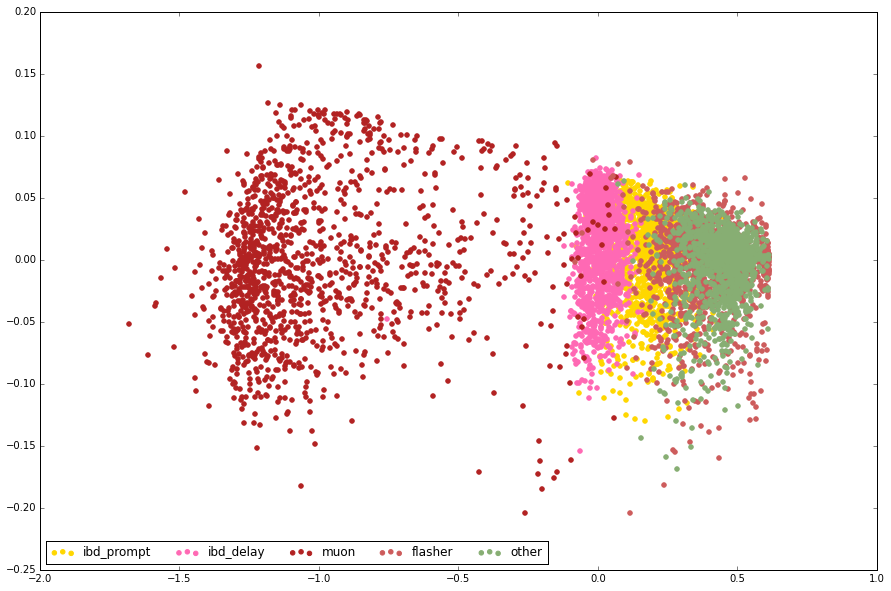

In [78]:
plt.rcParams['figure.figsize'] = 15, 10
for i in range(max(gr_truth) + 1):
    x = x_pca[gr_truth == i]
    plt.scatter(x[:,0], x[:,1],color=colors[i+1], label=labels[i])
plt.legend(loc='lower left', ncol= 5, fontsize=12)